# Business Location Predictor

**Can We Combine Census and Search Data to Predict Good Locations for New Businesses?**

by Corey Baughman

___

### Project Goal:

Create a model that uses census tract data for Bexar County and Google search of existing businesses to predict where to put a new yoga studio.

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import acquire as a
from env import api

# imports to deal with location data in Python
import geopandas as gpd
from shapely.geometry import Point

# imports to interact with google places API
import requests
import json

# preprocessing
from sklearn.model_selection import train_test_split

# modeling
from scipy.stats import pearsonr
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


___

## Acquire

* Three basic types of data were required:
    1. Census question data
    1. Census tract shapefile data
    1. Business search results data
* Select Census question data was acquired from U.S. Census Bureau website.
* Data was from the 2020 census.
* Data was downloaded as three .csv files and imported into pandas dataframes which were combined on census tract number a.k.a. 'geography'
* The data was limited to Bexar County, TX which has 375 census tracts. Each of these represents a row.
* The census tract shapefiles were required to assign point from search data into census tracts.
* The shapefiles were also retrieved from the U.S. Census Bureau website.
* Business search results data was retrieved using the Google Places API.
* Geopandas was then used to assign the locations retrieved to census tracts.

___

## Prepare

#### Data Cleaning Steps:
- Used following to clean data:
    1. Renamed columns to readable, pythonic names for each DataFrame.
    2. Standardized Geography names across DataFrames
    3. Dropped Columns from Census question DataFrames to select an initial feature set. (Entire tables must be downloaded as .csv and many features are heavily subsetted)
    4. Combined three census question DataFrames on 'geography' which was standardized and had 375 rows for every DataFrame.
    5. There were four federal tracts that had total populations of zero and those were dropped.
    6. Search results from Google Places were checked against census tracts to verify they were in Bexar County else they were dropped. 
    7. There were a total of 13 yoga studios in the county.
    8. Chose to ignore outliers for simplicity in the MVP and since underlying distibutions were not heavily skewed.
    9. There were no null values other than the four zero population tracts.


#####  The DataFrame for EDA (Transposed)

In [2]:
df = a.get_combined_data()
df.head().T

,0,1,2,3,4
geography,110100,110300,110500,110600,110700
total_pop,3153,3114,2430,5645,1079
sex_ratio,161.7,99.9,100.3,275.1,129.1
old_age_dep_ratio,29.0,13.0,25.4,15.0,49.2
child_dep_ratio,6.4,43.4,89.8,11.6,35.8
total_hispanic_latino,1758,1589,1982,4763,933
household_med_income,52659,43875,10518,16712,18700
centroid_lat,29.426165,29.41432,29.417071,29.429211,29.438939
centroid_long,-98.490526,-98.480848,-98.50908,-98.507837,-98.503691
latitude,NaN,NaN,NaN,NaN,NaN


___

## Explore

#### What features correlate with yoga studio locations? 

### Feature Distributions

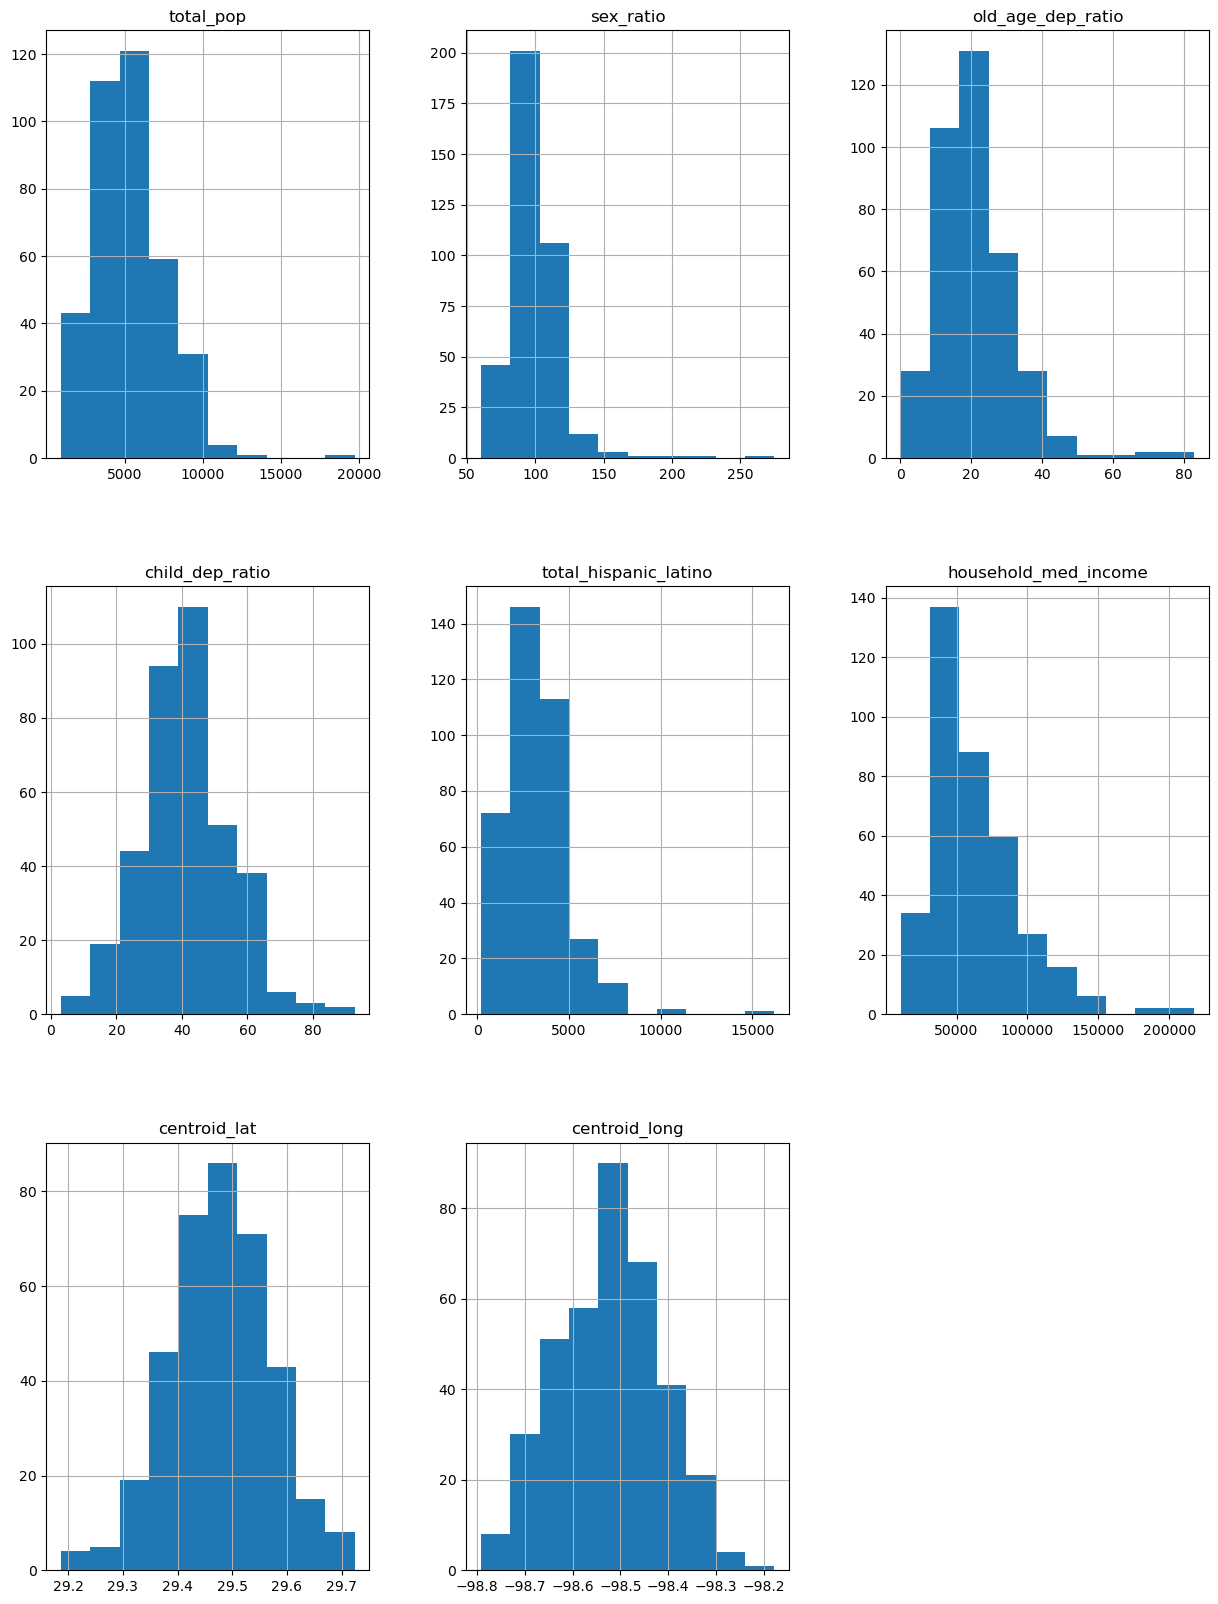

In [3]:
#Hist plot to show distribution of each column in the dataframe
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.drop(columns=['geography', 'latitude', 'longitude']).hist(ax = ax)
plt.show()

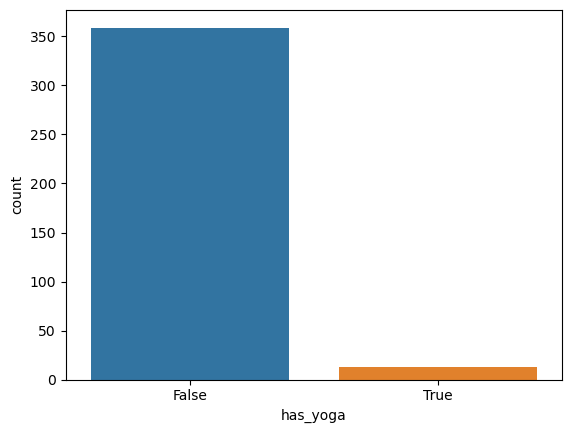

In [4]:
sns.countplot(data=df, x='has_yoga')
plt.show()

In [5]:
df.has_yoga.value_counts()

False    359
True      13
Name: has_yoga, dtype: int64

In [6]:
df.has_yoga.value_counts(normalize=True)

False    0.965054
True     0.034946
Name: has_yoga, dtype: float64

#### Insights from Univariate Exploration:

    1. Features are relatively normally distributed.
    2. Target classes are heavily imbalanced
    1. The sample size for the target is very small

#### Data Splitting
After univariate analysis, I split the dataset into train and test datasets. I did not have the luxury of a validation set due to the very small sample size. Further exploration is all conducted on the train dataset.

In [7]:
train, test = train_test_split(df, random_state=9751, 
                 stratify=df['has_yoga'], train_size = 0.7)

### Bivariate Analysis

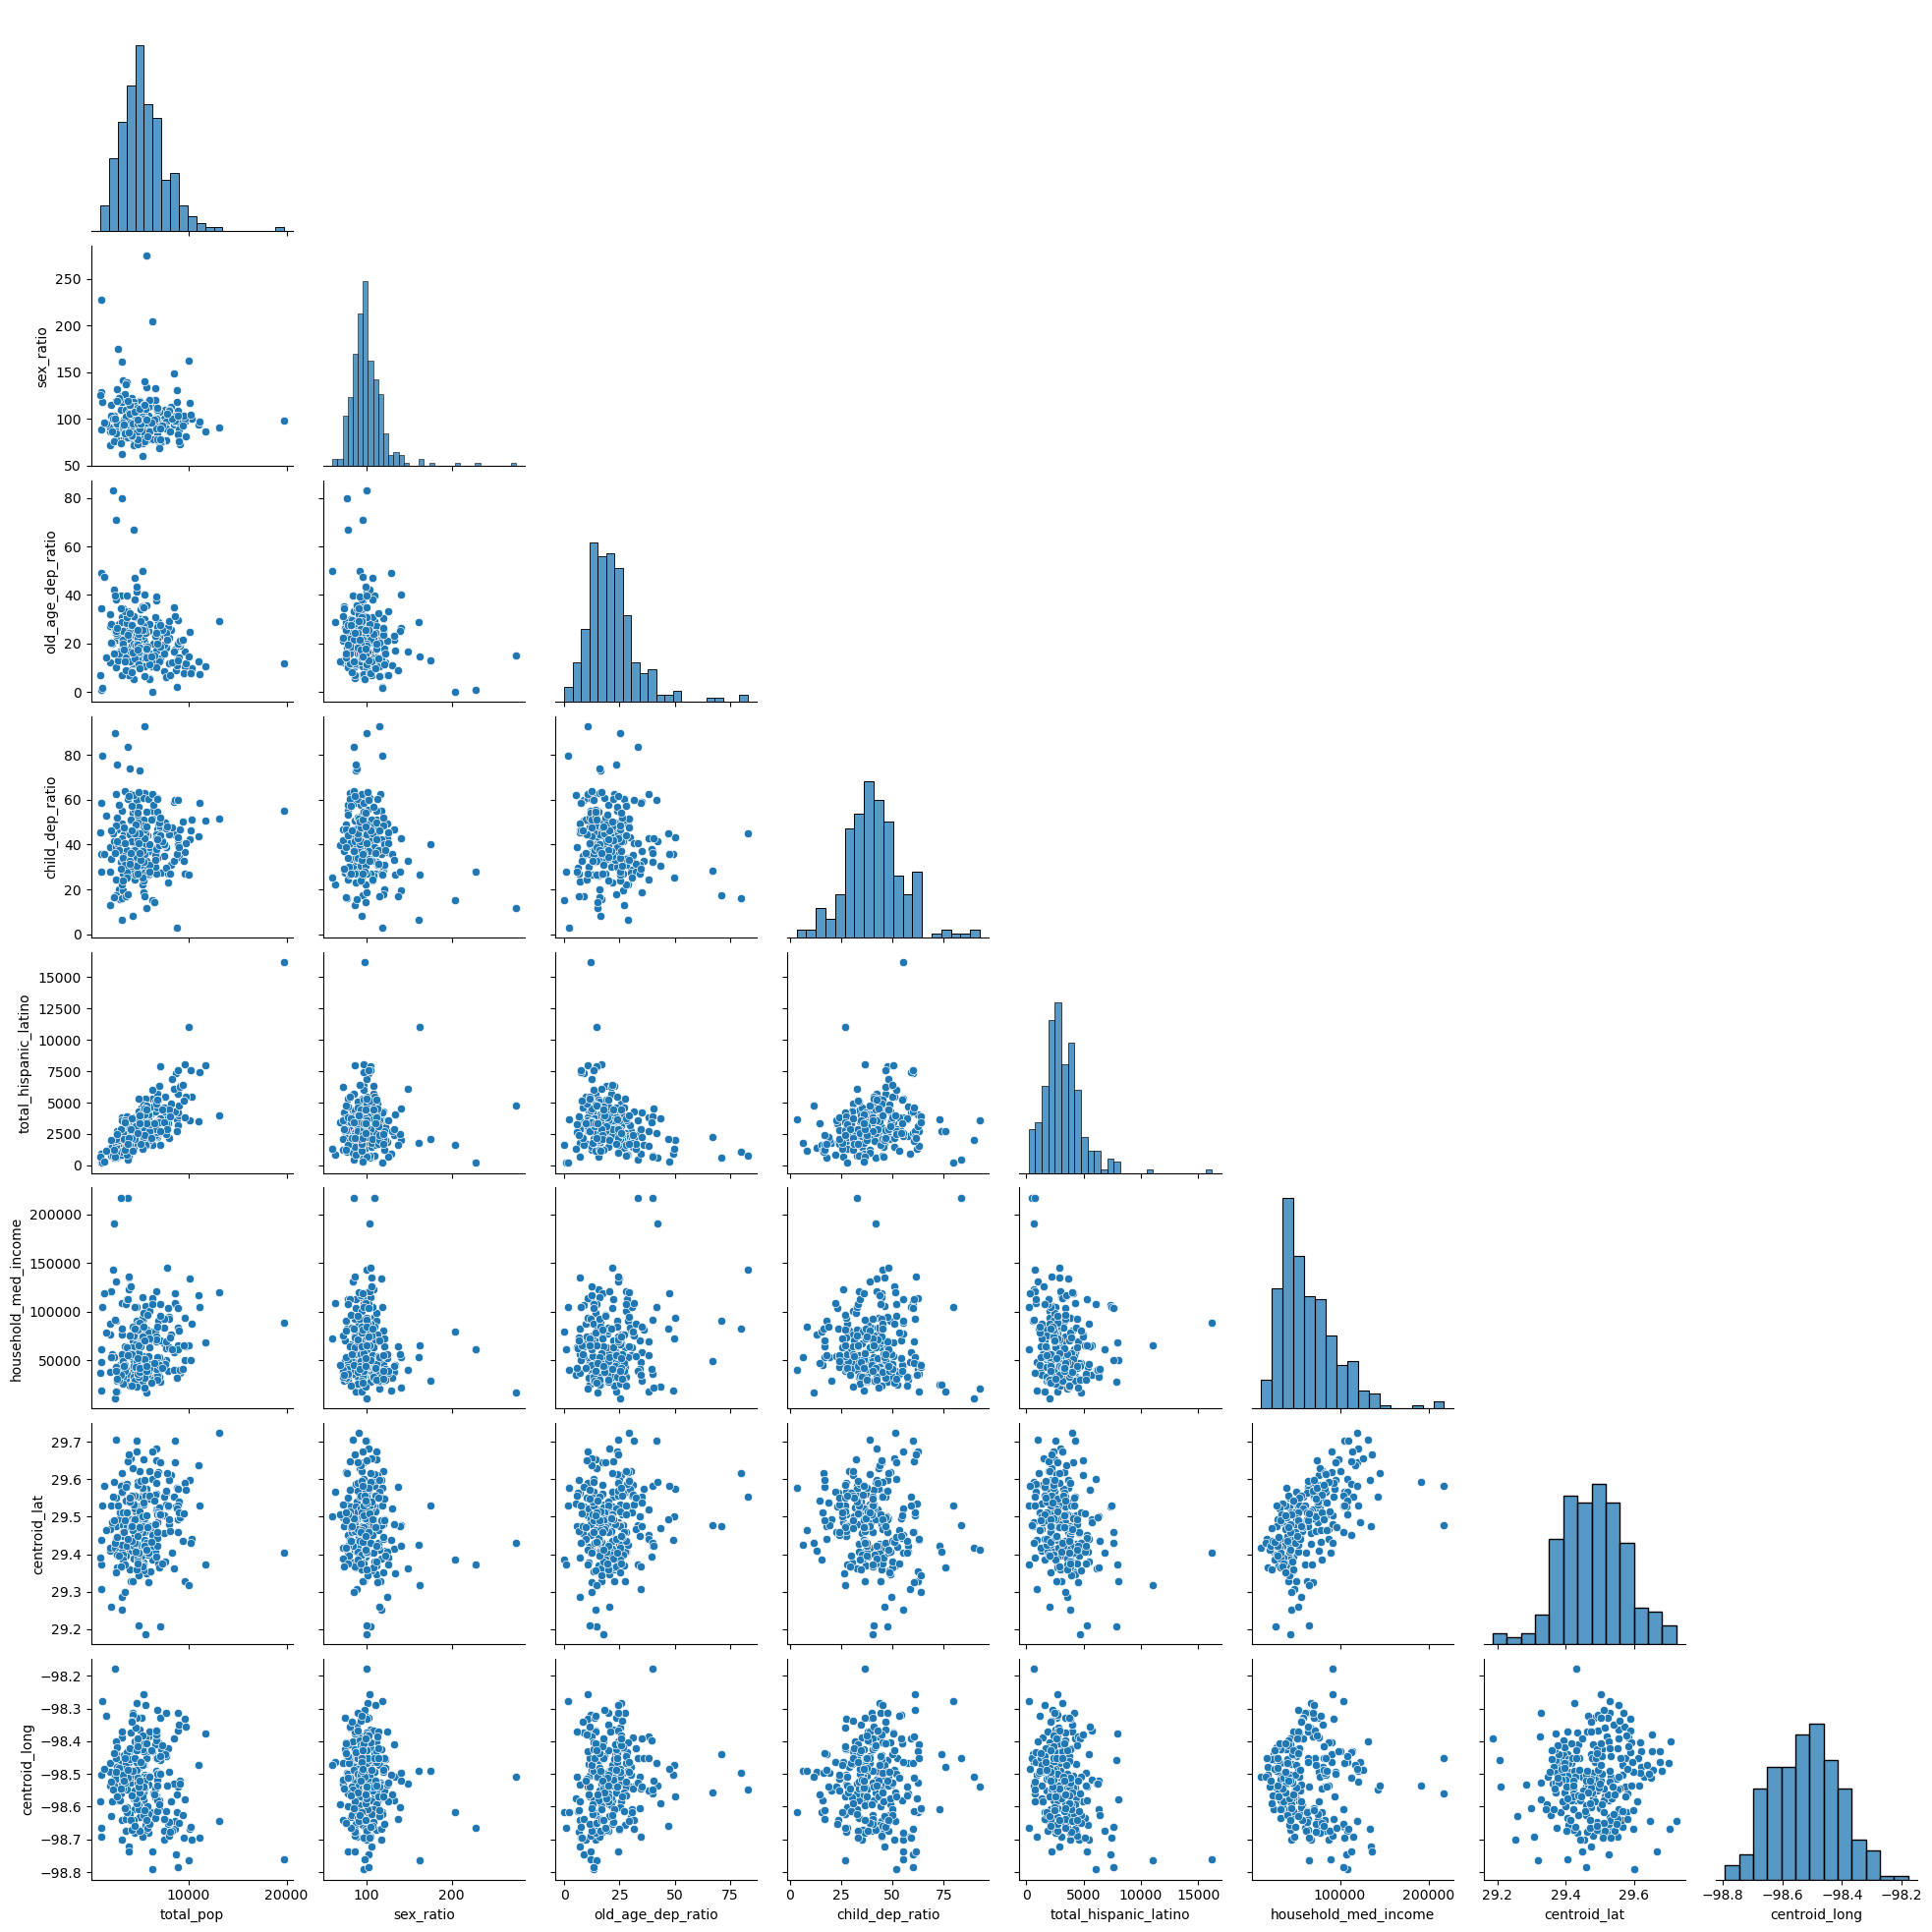

In [8]:
sns.pairplot(train.drop(columns=['geography', 'latitude', 'longitude', 'has_yoga']), corner=True)
plt.show()

In [9]:
# there appears to be a positive correlation between latitude and income

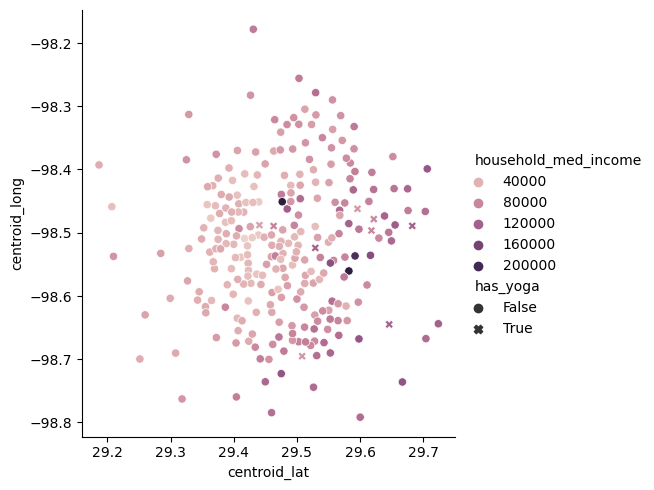

In [10]:
sns.relplot(data=train, x='centroid_lat', y='centroid_long', hue='household_med_income', style='has_yoga')
plt.show()

In [11]:
# it's hard to make out clear clusters in all dimensions here, but
# this does seem to show the correlation between income and yoga as
# well as wealth clusters on the northeast and southeast
# studios may be in poorer areas near richer areas which would make
# sense as rents may be lower, but still close enough to serve wealthy
# clients
# Going to explore clusters on these features with k between 2 and 10

In [12]:
target_col_name = 'has_yoga'
feature_target_corr = {}
for col in train.drop(columns=['geography', 'latitude', 'longitude']):
    if target_col_name != col:
        feature_target_corr[col + '_' + target_col_name] = \
            pearsonr(train[col], train[target_col_name])[0]\
            , pearsonr(train[col], train[target_col_name])[1]
print("Feature-Target Correlations, p-values")
print(feature_target_corr)

Feature-Target Correlations, p-values
{'total_pop_has_yoga': (-0.00618044368369202, 0.9209973987238368), 'sex_ratio_has_yoga': (-0.0003022736600612032, 0.9961298508792851), 'old_age_dep_ratio_has_yoga': (0.10953973337972217, 0.07788806507365327), 'child_dep_ratio_has_yoga': (-0.1698628787500684, 0.006037439234588488), 'total_hispanic_latino_has_yoga': (-0.09870146612035471, 0.1123487595138162), 'household_med_income_has_yoga': (0.1422055377858407, 0.02181259825233574), 'centroid_lat_has_yoga': (0.17251873049480732, 0.005281858578243495), 'centroid_long_has_yoga': (-0.01672982624145614, 0.7883303819744173)}


In [13]:
corrs = pd.DataFrame(feature_target_corr, index=['correlation', 'p-value'])
corrs.T

,correlation,p-value
total_pop_has_yoga,-0.006180,0.920997
sex_ratio_has_yoga,-0.000302,0.996130
old_age_dep_ratio_has_yoga,0.109540,0.077888
child_dep_ratio_has_yoga,-0.169863,0.006037
total_hispanic_latino_has_yoga,-0.098701,0.112349
household_med_income_has_yoga,0.142206,0.021813
centroid_lat_has_yoga,0.172519,0.005282
centroid_long_has_yoga,-0.016730,0.788330


In [14]:
# if we set alpha = 0.05,
# it looks like the only features that have a significant
# correlation to has_yoga are household_median_income, 
# child_dep_ratio and centroid_latitude

#### Insights from Bivariate Exploration:

    1. There are slight positive correlations between having a yoga studio and income as well as being further north geograpically
    2. There is a slight negative correlation between having a yoga studio and the child dependency ratio.

#### Separating features

In [15]:
# Separating features from target and dropping geography, lat, long for modeling:
X_train = train.drop(columns=['geography', 'latitude', 'longitude', 'has_yoga'])
X_test = test.drop(columns=['geography', 'latitude', 'longitude', 'has_yoga'])
y_train = train[['has_yoga']]
y_test = test[['has_yoga']]



In [16]:
# all features need scaling
X_cols = X_train.columns.tolist()
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_cols)


### Clustering

Goal: Explore whether there are useful clusters for predicting studio placement.

In [17]:
# Establish a baseline
# since has_studio=False is by far the dominant class
# will assign that as the baseline model.
y_train['baseline'] = False
y_test['baseline'] = False

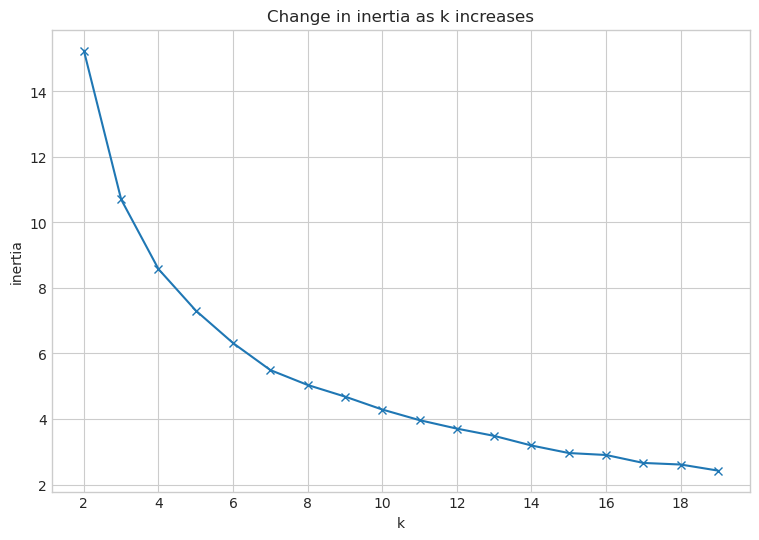

In [18]:
cluster_vars = ['household_med_income', 'centroid_lat', 'centroid_long']
X_train_clust = X_train_scaled[cluster_vars]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train_clust).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 20, 2))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


In [19]:
# we see a break between 3 and 7 which is consistent with what we saw in the viz.
# start with k = 5

In [20]:
k = 5
cluster_name = 'income_cluster'


In [21]:
def create_clusters(X_train_scaled, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans


In [22]:
kmeans = create_clusters(X_train_scaled, k, cluster_vars)


In [23]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df


In [24]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)


In [25]:
centroid_df

,income_cluster,centroid_household_med_income,centroid_centroid_lat,centroid_centroid_long
0,0,52543.511905,29.448278,-98.524027
1,1,115766.705882,29.590132,-98.571254
2,2,80171.109375,29.527266,-98.499147
3,3,32656.506667,29.426234,-98.510372
4,4,208628.666667,29.550196,-98.516154


In [26]:
# label cluster for each observation in X_train

clusters = pd.DataFrame(kmeans.predict(X_train[cluster_vars]), 
                    columns=[cluster_name], index=X_train.index)

clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

X_train = pd.concat([X_train, clusters_centroids], axis=1)


In [27]:
# label cluster for each observation in X_test

clusters = pd.DataFrame(kmeans.predict(X_test[cluster_vars]), 
                    columns=[cluster_name], index=X_test.index)

clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

X_test = pd.concat([X_test, clusters_centroids], axis=1)


In [28]:
X_train

,total_pop,sex_ratio,old_age_dep_ratio,child_dep_ratio,total_hispanic_latino,household_med_income,centroid_lat,centroid_long,income_cluster,centroid_household_med_income,centroid_centroid_lat,centroid_centroid_long
58,4998,104.6,22.3,46.7,2563,70101,29.554509,-98.365750,2,80171.109375,29.527266,-98.499147
41,6693,96.0,37.9,42.7,2697,69500,29.519699,-98.383996,2,80171.109375,29.527266,-98.499147
363,4955,119.3,30.3,28.9,1944,80024,29.621480,-98.478567,2,80171.109375,29.527266,-98.499147
273,4968,101.0,19.3,35.7,2708,76891,29.527821,-98.671639,2,80171.109375,29.527266,-98.499147
23,7668,76.7,18.1,39.0,3732,50146,29.532220,-98.445465,2,80171.109375,29.527266,-98.499147
...,...,...,...,...,...,...,...,...,...,...,...,...
304,5461,115.1,6.5,16.8,2451,70257,29.596946,-98.609920,1,115766.705882,29.590132,-98.571254
82,6154,96.1,14.5,51.0,2143,26332,29.432014,-98.426944,1,115766.705882,29.590132,-98.571254
203,5718,99.4,17.9,48.0,4427,44197,29.413117,-98.639374,4,208628.666667,29.550196,-98.516154
194,2682,119.7,26.2,51.9,2514,30556,29.445414,-98.567393,4,208628.666667,29.550196,-98.516154


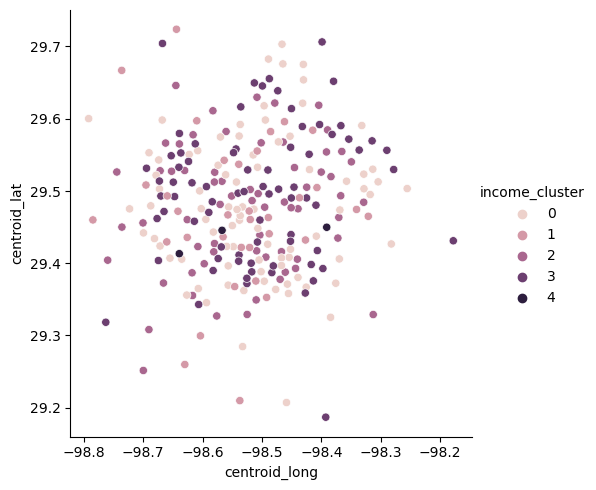

In [29]:
sns.relplot(data = X_train, x='centroid_long', y='centroid_lat', hue='income_cluster')

#### Clustering Summary:

- visually, there are no distinct clusters at k=3 to k=7
- will add clusters with k=5 as a feature for modeling anyway.

### Exploration Summary: What Drives Studio Placement?
1. higher household median income
2. placement further north in the county
3. lower child dependency ratio
4. Initial clustering exploration did not produce strong clusters visually


## Modeling

### Introduction

#### **Goal:** The goal of my modeling phase is to build a model that predicts whether a census tract will have a yoga studio.
    
#### **Evaluation**: Models will be evaluated by the recall metric:
    1. against a baseline model by accuracy
        - accuracy measures total number of correct predictions over the total number of observations. It is a useful measure against the baseline model
    2. against each other using recall
        - recall measures the number of True Positive Predictions divided by total number of actual positive observations. I'm using it because I want to cast a wide net for areas that may be good candidates for a studio. It can't be checked against baseline, but is the best measure for these models against each other.
        
#### The baseline model is created by replacing all predicted values with the most common class from the actual values. In this case that is 'False' for no yoga studio in the census tract.

In [30]:
rf1 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)
rf1.fit(X_train, y_train.has_yoga)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=123)

In [31]:
print(rf1.feature_importances_)


[0.0887587  0.06024065 0.0827579  0.13054891 0.12990462 0.10934281
 0.12823349 0.1132007  0.02032611 0.03167654 0.05407922 0.05093034]


In [32]:
# it appears cluster is one of the less important features

In [33]:
y_pred = rf1.predict(X_train)

In [34]:
y_pred_proba = rf1.predict_proba(X_train)


In [35]:
print('Accuracy of random forest classifier on training set: {:.6f}'
     .format(rf1.score(X_train, y_train.has_yoga)))


Accuracy of random forest classifier on training set: 0.976923


In [36]:
print(confusion_matrix(y_train.has_yoga, y_pred))


[[251   0]
 [  6   3]]


In [37]:
# this is at least beating baseline

In [38]:
# v. baseline
print(confusion_matrix(y_train.has_yoga, y_train.baseline))


[[251   0]
 [  9   0]]


In [39]:
print(classification_report(y_train.has_yoga, y_pred))


              precision    recall  f1-score   support

       False       0.98      1.00      0.99       251
        True       1.00      0.33      0.50         9

    accuracy                           0.98       260
   macro avg       0.99      0.67      0.74       260
weighted avg       0.98      0.98      0.97       260



In [40]:
# baseline performance:
print(classification_report(y_train.has_yoga, y_train.baseline))

              precision    recall  f1-score   support

       False       0.97      1.00      0.98       251
        True       0.00      0.00      0.00         9

    accuracy                           0.97       260
   macro avg       0.48      0.50      0.49       260
weighted avg       0.93      0.97      0.95       260



In [41]:
# recall on the True class is the metric of interest as some false positives 
# may indicate areas that would be good locations for studios but don't have them yet.
# at .33 it is at least beating baseline.

### Test Model

* Now I will run this model on the Test dataset that was reserved as part of the splitting process to simulate performace of the churn predictions 'in the wild'

In [42]:
y_pred_test = rf1.predict(X_test)

In [43]:
print(classification_report(y_test.has_yoga, y_pred_test))


              precision    recall  f1-score   support

       False       0.96      1.00      0.98       108
        True       0.00      0.00      0.00         4

    accuracy                           0.96       112
   macro avg       0.48      0.50      0.49       112
weighted avg       0.93      0.96      0.95       112



In [44]:
print(confusion_matrix(y_test.has_yoga, y_pred_test))


[[108   0]
 [  4   0]]


In [45]:
# with a recall score of zero, this model did not beat baseline in the wild yet.

### Modeling Wrap 
* With an accuracy of .96 and a recall of 0.00 for the True class, the current Random Forest Classifier model fails to beat the baseline model of guessing 'no studio' for any given census tract.

## Conclusion

### Summary
* Some drivers of business placement were found
* The current classification model fails to beat baseline 


### Next Steps
1. Add features that measure distance between studios and tract centroids
2. Explore other algorithms for modeling
3. Test with a larger dataset
4. Work on balancing classes